<a href="https://colab.research.google.com/github/yoshinari1209/rlss2025/blob/main/RL2025_final_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RL Summer 2025 最終課題

## テーマ : 「宝くじ仮説」を深層強化学習で検証

### 宝くじ仮説とは
（個人の適当な解釈です）
- 宝くじ仮説（Lottery Ticket Hypothesis; LTH）は、大きな（密な）ネットワークの中には、初期化を保ったまま、単独でよく学習できる「当たりクジ（小さな疎なサブネット）」が潜んでいる

## 【実験方法】

### 目的
- **宝くじ仮説 (LTH)** 検証：密ネットの学習後、最終重みの小さい|w|から**反復マグニチュード・プルーニング（IMP）**でサブネット（マスク）を作成。
- 早期時点 **t₀** へ**リワインド**してマスク適用のまま再学習し、**密ネットに匹敵する学習挙動**が再現できるかを比較する。

---

### タスクとモデル
- **DQN×CartPole-v1**  
  - Q関数近似：MLP(128→128)→出力2  
  - 総学習ステップ `TOTAL_STEPS=50k`、リワインド時点 `T0_STEPS=5k`
- **MNIST×分類器（パラメータ17,410でQNetと一致）**  
  - conv(1→7,k3) → pool → conv(7→2,k3) → pool → fc(50→282) → fc(282→10)  
  - 総更新回数 = `EPOCHS × |train_loader|`、リワインド時点 `t₀=10%`（`MNIST_T0_FRAC=0.1`）

---

### 手順
1. **密学習（baseline）**  
   - 乱数 **seed固定=0**。  
   - 学習曲線を記録（CartPole: エピソード報酬、MNIST: テスト/検証精度）。  
   - `t₀` で**重みスナップショット**を保存。

2. **IMPマスク作成（最終重みベース）**  
   - 対象：各層の `weight`。  
   - 目標疎度：`[0.5, 0.8, 0.9, 0.95]`（0.0は密の対照）。  
   - 1反復あたりの削減率：`PRUNE_STEP_FRACTION=0.2`（≒生存パラメータの20%ずつ小さい順に0へ）。  
   - **mag**：マグニチュード順マスク。  
   - **rand**：各層の**ゼロ数だけ一致**させたランダムマスク（対照）。

3. **t₀へリワインド＋マスク適用で再学習**  
   - `t₀` の重みに戻し、マスクを適用（勾配・更新で 0 が復活しないよう投影＆ゼロ化）。  
   - **mag** と **rand** を同条件で再学習し、学習曲線を取得。

---

### 評価指標と LTH 判定
- **学習曲線**：  
  - CartPole：エピソード報酬 vs 学習ステップ  
  - MNIST：精度 vs 更新ステップ（各エポック終端で評価）
- **AUC（normalized）**：曲線の面積 /（最大面積）  
  - CartPole：最大面積 = `TOTAL_STEPS × 500`  
  - MNIST：最大面積 = `total_steps × 1.0`
- **Best**：曲線の最大値（CartPole: 最高報酬、MNIST: 最高精度）
- **（任意）ThrStep**：曲線が閾値に**初到達**する更新ステップ（MNIST例：精度 0.97）

**LTH 判定**  
- 基本：**AUC 基準** … 候補（mag/rand）の `AUC_norm` が **dense の 95%以上**  
- バリアント：**ThrStep 基準** … 候補の到達ステップが **dense ±10%以内**（参考/補助）

# 1.DQNで宝くじ仮説を検証

Device: cuda  |  SEED: 0


dense | seed=0:   0%|          | 0/50000 [00:00<?, ?it/s]

Sparsities:   0%|          | 0/4 [00:00<?, ?it/s]

mag@50%:   0%|          | 0/50000 [00:00<?, ?it/s]

rand@50%:   0%|          | 0/50000 [00:00<?, ?it/s]

mag@80%:   0%|          | 0/50000 [00:00<?, ?it/s]

rand@80%:   0%|          | 0/50000 [00:00<?, ?it/s]

mag@90%:   0%|          | 0/50000 [00:00<?, ?it/s]

rand@90%:   0%|          | 0/50000 [00:00<?, ?it/s]

mag@95%:   0%|          | 0/50000 [00:00<?, ?it/s]

rand@95%:   0%|          | 0/50000 [00:00<?, ?it/s]

集計（seed=0, 1回のみ / LTH=AUC_norm ≥ 95% * dense）:


,kind,sparsity,LTH,AUC_norm,BestRet,FinalRet
0,dense,0.00,NaN,0.169277,352.0,99.0
1,mag,0.50,True,0.220527,401.0,111.0
2,mag,0.80,False,0.159458,439.0,171.0
3,mag,0.90,False,0.047719,94.0,38.0
4,mag,0.95,False,0.027556,81.0,8.0
5,rand,0.50,True,0.301179,500.0,500.0
6,rand,0.80,True,0.352583,500.0,229.0
7,rand,0.90,False,0.144207,341.0,57.0
8,rand,0.95,False,0.039898,99.0,10.0


/tmp/ipython-input-4210728003.py:330: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("tab10")


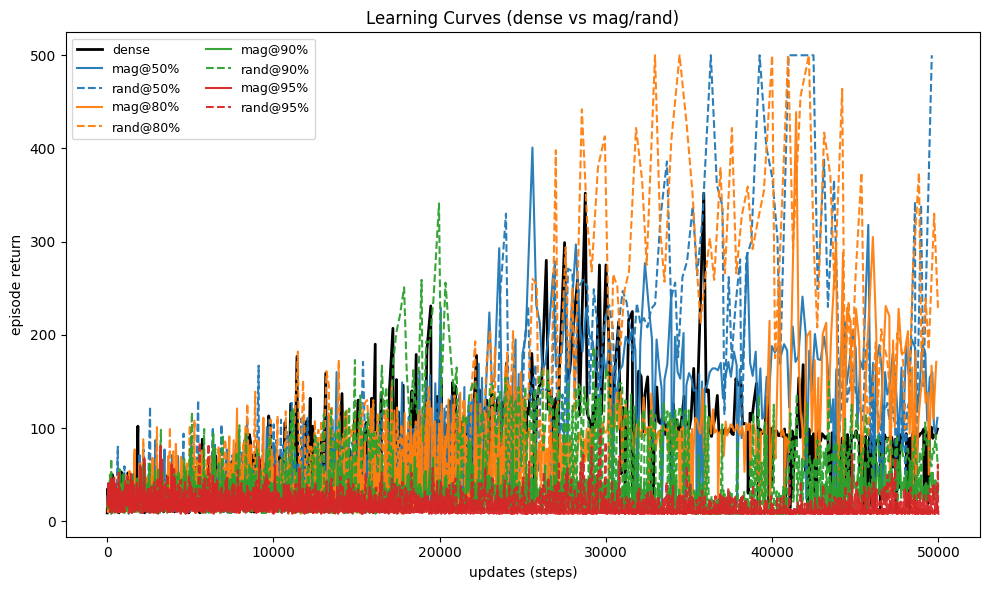

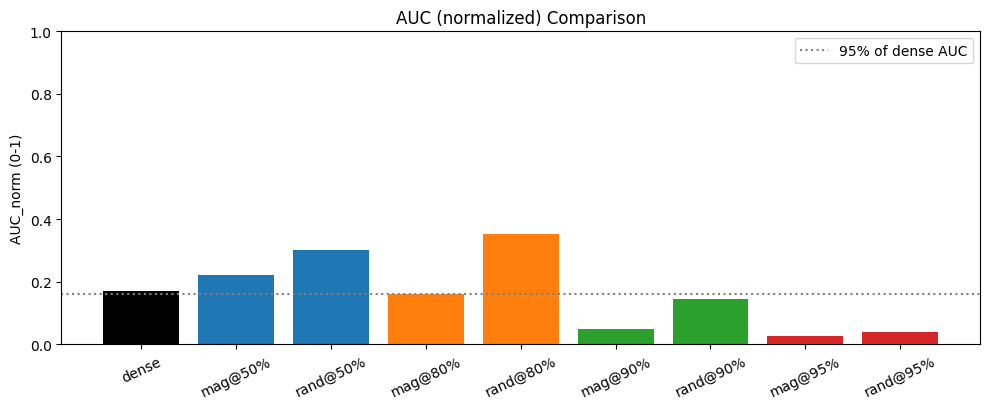

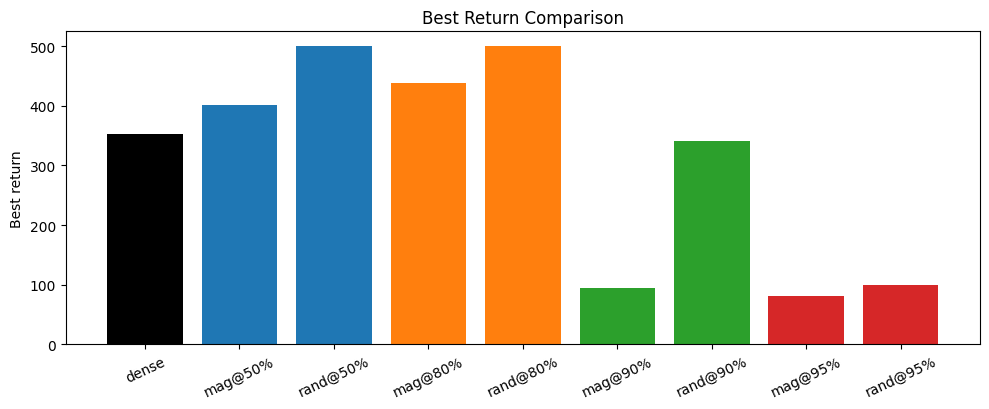


=== 動画出力（各設定で1エピソード実行 / eps=0.01） ===


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


dense: return=94.0  -> videos/dense-episode-0.mp4


mag@50%: return=199.0  -> videos/mag_at_50pct-episode-0.mp4


rand@50%: return=500.0  -> videos/rand_at_50pct-episode-0.mp4


mag@80%: return=180.0  -> videos/mag_at_80pct-episode-0.mp4


rand@80%: return=344.0  -> videos/rand_at_80pct-episode-0.mp4


mag@90%: return=33.0  -> videos/mag_at_90pct-episode-0.mp4


rand@90%: return=146.0  -> videos/rand_at_90pct-episode-0.mp4


mag@95%: return=10.0  -> videos/mag_at_95pct-episode-0.mp4


rand@95%: return=9.0  -> videos/rand_at_95pct-episode-0.mp4


In [2]:
# @markdown **ポイント**
# @markdown - LTH判定: **denseのAUC_norm比 ≥ 95%**
# @markdown - プロット: **①学習曲線 ②AUC比較 ③BestReturn比較**
# @markdown - 各設定（dense/mag/rand×疎度）で **CartPoleの動画(mp4)を自動保存＆表示**
# @markdown 実験パラメータ（軽量テスト→提出時に変更）

# ========= 実験パラメータ =========
ENV_NAME = "CartPole-v1" # @param ["CartPole-v1"]
TOTAL_STEPS = 50_000      # @param {type:"integer"}  # 総学習ステップ数（オンライン収集＋更新）
T0_STEPS = 5_000          # @param {type:"integer"}  # リワインド用のスナップショットを取る時点
TARGET_SPARSITIES = [0.0, 0.5, 0.8, 0.9, 0.95]  # @param  # 目標疎度（0は密ネットのベースライン）
PRUNE_STEP_FRACTION = 0.2 # @param {type:"number"}  # 反復プルーニング時の1回あたり削減率（20%）
USE_TQDM = True           # @param {type:"boolean"}  # tqdmの進捗バーを表示
PROGRESS_UPDATE_EVERY = 1 # @param {type:"integer"}  # 進捗バーの更新間隔（ステップごと）。重い場合は100などに
AUC_RATIO_REQ = 0.95      # @param {type:"number"}   LTH判定のAUCしきい（dense比）

# ========= SETUP =========
!pip -q install gymnasium[classic-control] numpy matplotlib pandas tqdm

import os, glob, math, random, copy, time
from collections import deque
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from IPython.display import display, Video

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 0  # ← seed固定1回のみ

def set_global_seed(seed: int):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

# ========= Replay Buffer =========
class ReplayBuffer:
    def __init__(self, capacity=50_000):
        self.mem = deque(maxlen=capacity)
    def push(self, s, a, r, s2, d): self.mem.append((s,a,r,s2,d))
    def sample(self, batch_size=64):
        idxs = np.random.choice(len(self.mem), size=batch_size, replace=False)
        s, a, r, s2, d = zip(*[self.mem[i] for i in idxs])
        return (np.array(s, np.float32),
                np.array(a, np.int64),
                np.array(r, np.float32),
                np.array(s2, np.float32),
                np.array(d, np.float32))
    def __len__(self): return len(self.mem)

# ========= Q-Network =========
class QNet(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, act_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x)); x = F.relu(self.fc2(x))
        return self.out(x)

# ========= DQN Agent（マスク対応） =========
class DQNAgent:
    def __init__(self, obs_dim, act_dim, lr=1e-3, gamma=0.99, tau=None, target_update=1000):
        self.q = QNet(obs_dim, act_dim).to(device)
        self.target = QNet(obs_dim, act_dim).to(device)
        self.target.load_state_dict(self.q.state_dict())
        self.optim = torch.optim.Adam(self.q.parameters(), lr=lr)
        self.gamma = gamma
        self.tau = tau
        self.target_update = target_update
        self.update_steps = 0
        self._masks = []  # list[(param_ref, mask_tensor)]

    def act(self, obs, eps):
        if random.random() < eps:
            return random.randrange(self.q.out.out_features)
        with torch.no_grad():
            q = self.q(torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0))
            return int(q.argmax(dim=1).item())

    def register_masks(self, masks):
        layers = [self.q.fc1, self.q.fc2, self.q.out]
        self._masks = [(layer.weight, mask.to(device)) for layer, mask in zip(layers, masks)]

    def _project_to_masks(self):
        for W, M in self._masks: W.data.mul_(M)
    def _zero_pruned_grads(self):
        for W, M in self._masks:
            if W.grad is not None: W.grad.data.mul_(M)

    def update(self, rb: ReplayBuffer, batch=64):
        if len(rb) < 1000: return
        s, a, r, s2, d = rb.sample(batch)
        s = torch.tensor(s, dtype=torch.float32, device=device)
        a = torch.tensor(a, dtype=torch.int64, device=device).unsqueeze(1)
        r = torch.tensor(r, dtype=torch.float32, device=device).unsqueeze(1)
        s2= torch.tensor(s2,dtype=torch.float32, device=device)
        d = torch.tensor(d, dtype=torch.float32, device=device).unsqueeze(1)

        q = self.q(s).gather(1, a)
        with torch.no_grad():
            qn = self.target(s2).max(1, keepdim=True)[0]
            tgt = r + (1.0 - d) * self.gamma * qn
        loss = F.smooth_l1_loss(q, tgt)

        self.optim.zero_grad(); loss.backward()
        self._zero_pruned_grads(); self.optim.step(); self._project_to_masks()

        self.update_steps += 1
        if self.tau is None:
            if self.update_steps % self.target_update == 0:
                self.target.load_state_dict(self.q.state_dict())
        else:
            with torch.no_grad():
                for p, tp in zip(self.q.parameters(), self.target.parameters()):
                    tp.data.mul_(1 - self.tau).add_(self.tau * p.data)

# ========= Epsilon schedule =========
def linear_eps(step, eps_start=1.0, eps_end=0.05, decay_steps=30_000):
    if step >= decay_steps: return eps_end
    return eps_start - (eps_start - eps_end) * (step / decay_steps)

# ========= Training =========
def train_dqn(seed, total_steps=50_000, t0_steps=5_000, desc="dense"):
    set_global_seed(seed)
    env = gym.make(ENV_NAME)
    obs, info = env.reset(seed=seed)
    obs_dim = env.observation_space.shape[0]; act_dim = env.action_space.n
    agent = DQNAgent(obs_dim, act_dim, lr=1e-3, gamma=0.99, tau=None, target_update=1000)
    rb = ReplayBuffer(50_000)

    step=0; episode=0; ep_ret=0.0
    curve_steps=[]; curve_returns=[]; t0_state=None
    pbar = tqdm(total=total_steps, desc=f"{desc} | seed={seed}", leave=False) if USE_TQDM else None

    while step < total_steps:
        a = agent.act(obs, linear_eps(step))
        nobs, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated
        rb.push(obs,a,r,nobs,float(done))
        obs = nobs; ep_ret += r; step += 1
        agent.update(rb, 64)
        if pbar and (step % PROGRESS_UPDATE_EVERY == 0):
            pbar.update(PROGRESS_UPDATE_EVERY if step <= total_steps else total_steps - (step - PROGRESS_UPDATE_EVERY))
        if step == t0_steps: t0_state = copy.deepcopy(agent.q.state_dict())
        if done:
            curve_steps.append(step); curve_returns.append(ep_ret); ep_ret=0.0
            obs,_ = env.reset()
    if pbar: pbar.close()
    env.close()
    if t0_state is None: t0_state = copy.deepcopy(agent.q.state_dict())
    return agent, (np.array(curve_steps), np.array(curve_returns)), t0_state, (obs_dim, act_dim)

# ========= Pruning utils =========
def get_linear_weights(model: QNet):
    return [model.fc1.weight.detach().cpu(),
            model.fc2.weight.detach().cpu(),
            model.out.weight.detach().cpu()]

def iterative_magnitude_prune_masks(weights_by_layer, target_sparsity=0.9, step_fraction=0.2):
    masks = [torch.ones_like(W) for W in weights_by_layer]
    total_elems = sum(W.numel() for W in weights_by_layer)
    target_zeros = int(total_elems * target_sparsity)
    def current_zeros(): return sum(int((m == 0).sum().item()) for m in masks)
    while current_zeros() < target_zeros:
        mags = torch.cat([torch.abs(W[m.bool()]).flatten() for W, m in zip(weights_by_layer, masks)])
        if mags.numel() == 0: break
        k = max(1, int(mags.numel() * step_fraction))
        thresh = torch.topk(mags, k, largest=False).values.max()
        for li, (W, m) in enumerate(zip(weights_by_layer, masks)):
            sel = (m == 1) & (torch.abs(W) <= thresh)
            masks[li][sel] = 0
    return masks

def random_masks_like(mag_masks, rng: np.random.Generator):
    rand_masks = []
    for M in mag_masks:
        M = M.clone()
        zeros = (M == 0).sum().item()
        flat = torch.ones_like(M).flatten()
        idx = rng.permutation(flat.numel())[:zeros]
        flat[idx] = 0
        rand_masks.append(flat.view_as(M))
    return rand_masks

def apply_masks_to_agent(agent: DQNAgent, masks):
    agent.register_masks(masks); agent._project_to_masks()

# ========= Metrics（AUC＋Best/Final Return） =========
def compute_metrics_auc_and_best(curve_steps, curve_returns, total_steps, y_max=500.0):
    steps = np.clip(np.asarray(curve_steps), 0, total_steps)
    vals  = np.asarray(curve_returns, dtype=np.float32)
    if len(steps) == 0:
        return dict(AUC_norm=0.0, BestRet=0.0, FinalRet=0.0)
    uniq_steps, uniq_idx = np.unique(steps, return_index=True)
    vals = vals[uniq_idx]
    auc = np.trapezoid(vals, uniq_steps) if len(vals) > 1 else 0.0
    auc_norm = float(auc / (total_steps * y_max))
    best_ret = float(np.max(vals)) if len(vals)>0 else 0.0
    final_ret = float(vals[-1]) if len(vals)>0 else 0.0
    return dict(AUC_norm=auc_norm, BestRet=best_ret, FinalRet=final_ret)

def lth_by_auc_only(dense_auc_norm, cand_auc_norm, ratio_req=AUC_RATIO_REQ):
    return cand_auc_norm >= ratio_req * max(1e-12, dense_auc_norm)

# ========= 動画出力（各条件のポリシーを1エピソード実行） =========
def record_policy_video(agent: DQNAgent, env_name: str, tag: str, seed: int, video_dir="videos", eps=0.01, max_steps=1000):
    os.makedirs(video_dir, exist_ok=True)
    # Gymnasium の RecordVideo を使用（render_mode="rgb_array" が必要）
    from gymnasium.wrappers import RecordVideo
    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(env, video_folder=video_dir, name_prefix=tag, episode_trigger=lambda e: True)
    obs, info = env.reset(seed=seed)
    total_r = 0.0
    for _ in range(max_steps):
        a = agent.act(obs, eps)
        obs, r, terminated, truncated, _ = env.step(a)
        total_r += r
        if terminated or truncated: break
    env.close()
    # 生成された mp4 を探す
    pattern = os.path.join(video_dir, f"{tag}-episode-*.mp4")
    files = sorted(glob.glob(pattern))
    return files[-1] if files else None, total_r

# ========= 実行（seed固定=0の1回のみ） =========
print(f"Device: {device}  |  SEED: {SEED}")
start = time.time()

# 1) Dense 学習
agent_dense, (steps_dense, rets_dense), t0_state, (obs_dim, act_dim) = train_dqn(SEED, total_steps=TOTAL_STEPS, t0_steps=T0_STEPS, desc="dense")
dense_metrics = compute_metrics_auc_and_best(steps_dense, rets_dense, total_steps=TOTAL_STEPS, y_max=500.0)

# 2) マスク生成（最終密重みから）
weights_final = get_linear_weights(agent_dense.q)

# 3) 各疎度で mag/rand をリワインド再学習
rows = []
agents = {"dense": agent_dense}           # ← 動画用に保存
curves = {"dense": (steps_dense, rets_dense)}
rows.append(dict(kind="dense", sparsity=0.0, **dense_metrics))

if USE_TQDM:
    sp_iter = tqdm([sp for sp in TARGET_SPARSITIES if sp!=0.0], desc="Sparsities")
else:
    sp_iter = [sp for sp in TARGET_SPARSITIES if sp!=0.0]

for sp in sp_iter:
    # mag
    mag_masks = iterative_magnitude_prune_masks(weights_final, target_sparsity=sp, step_fraction=PRUNE_STEP_FRACTION)
    agent_mag = DQNAgent(obs_dim, act_dim)
    agent_mag.q.load_state_dict(copy.deepcopy(t0_state))
    agent_mag.target.load_state_dict(agent_mag.q.state_dict())
    apply_masks_to_agent(agent_mag, mag_masks)

    # 再学習（進捗）
    env = gym.make(ENV_NAME)
    obs,_ = env.reset(seed=SEED+123)
    rb = ReplayBuffer(50_000)
    step=0; ep_ret=0.0; s_m=[]; r_m=[]
    pbar = tqdm(total=TOTAL_STEPS, desc=f"mag@{int(sp*100)}%", leave=False) if USE_TQDM else None
    while step < TOTAL_STEPS:
        a = agent_mag.act(obs, linear_eps(step))
        nobs, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated
        rb.push(obs,a,r,nobs,float(done))
        obs = nobs; ep_ret += r; step += 1
        agent_mag.update(rb, 64)
        if pbar and (step % PROGRESS_UPDATE_EVERY == 0):
            pbar.update(PROGRESS_UPDATE_EVERY if step <= TOTAL_STEPS else TOTAL_STEPS - (step - PROGRESS_UPDATE_EVERY))
        if done:
            s_m.append(step); r_m.append(ep_ret); ep_ret=0.0
            obs,_ = env.reset()
    if pbar: pbar.close(); env.close()
    m_met = compute_metrics_auc_and_best(np.array(s_m), np.array(r_m), total_steps=TOTAL_STEPS, y_max=500.0)
    flag_m = lth_by_auc_only(dense_metrics["AUC_norm"], m_met["AUC_norm"])
    rows.append(dict(kind="mag", sparsity=sp, LTH=flag_m, **m_met))
    curves[f"mag@{int(sp*100)}%"] = (np.array(s_m), np.array(r_m))
    agents[f"mag@{int(sp*100)}%"] = agent_mag

    # rand
    rng = np.random.default_rng(SEED + int(sp*1000) + 999)
    rand_masks = random_masks_like(mag_masks, rng)
    agent_rand = DQNAgent(obs_dim, act_dim)
    agent_rand.q.load_state_dict(copy.deepcopy(t0_state))
    agent_rand.target.load_state_dict(agent_rand.q.state_dict())
    apply_masks_to_agent(agent_rand, rand_masks)

    env = gym.make(ENV_NAME)
    obs,_ = env.reset(seed=SEED+456)
    rb = ReplayBuffer(50_000)
    step=0; ep_ret=0.0; s_r=[]; r_r=[]
    pbar = tqdm(total=TOTAL_STEPS, desc=f"rand@{int(sp*100)}%", leave=False) if USE_TQDM else None
    while step < TOTAL_STEPS:
        a = agent_rand.act(obs, linear_eps(step))
        nobs, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated
        rb.push(obs,a,r,nobs,float(done))
        obs = nobs; ep_ret += r; step += 1
        agent_rand.update(rb, 64)
        if pbar and (step % PROGRESS_UPDATE_EVERY == 0):
            pbar.update(PROGRESS_UPDATE_EVERY if step <= TOTAL_STEPS else TOTAL_STEPS - (step - PROGRESS_UPDATE_EVERY))
        if done:
            s_r.append(step); r_r.append(ep_ret); ep_ret=0.0
            obs,_ = env.reset()
    if pbar: pbar.close(); env.close()
    r_met = compute_metrics_auc_and_best(np.array(s_r), np.array(r_r), total_steps=TOTAL_STEPS, y_max=500.0)
    flag_r = lth_by_auc_only(dense_metrics["AUC_norm"], r_met["AUC_norm"])
    rows.append(dict(kind="rand", sparsity=sp, LTH=flag_r, **r_met))
    curves[f"rand@{int(sp*100)}%"] = (np.array(s_r), np.array(r_r))
    agents[f"rand@{int(sp*100)}%"] = agent_rand

elapsed = time.time() - start

# ========= 集計（AUC基準） =========
df = pd.DataFrame(rows)
df = df[["kind","sparsity","LTH","AUC_norm","BestRet","FinalRet"]]
print("集計（seed=0, 1回のみ / LTH=AUC_norm ≥ %.0f%% * dense）:" % (AUC_RATIO_REQ*100))
display(df.sort_values(["kind","sparsity"]).reset_index(drop=True))

# ========= 可視化（3プロット） =========
import matplotlib as mpl
cmap = mpl.cm.get_cmap("tab10")
sp_list = [sp for sp in TARGET_SPARSITIES if sp!=0.0]
color_map = {sp: cmap(i % 10) for i, sp in enumerate(sp_list)}

# (1) 学習曲線
plt.figure(figsize=(10,6))
s, r = curves["dense"]
plt.plot(s, r, label="dense", color="black", linewidth=2)
for sp in sp_list:
    sm, rm = curves[f"mag@{int(sp*100)}%"]
    sr, rr = curves[f"rand@{int(sp*100)}%"]
    plt.plot(sm, rm, label=f"mag@{int(sp*100)}%", color=color_map[sp], alpha=0.95)
    plt.plot(sr, rr, label=f"rand@{int(sp*100)}%", color=color_map[sp], linestyle="--", alpha=0.95)
plt.xlabel("updates (steps)")
plt.ylabel("episode return")
plt.title("Learning Curves (dense vs mag/rand)")
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

# (2) AUC比較
order = [("dense",0.0)] + [(k,sp) for sp in sp_list for k in ("mag","rand")]
labels_auc, vals_auc, cols_auc = [], [], []
dense_auc = df[(df["kind"]=="dense") & (df["sparsity"]==0.0)]["AUC_norm"].values[0]
for kind, sp in order:
    row = df[(df["kind"]==kind) & (df["sparsity"]==sp)]
    if len(row)==0: continue
    labels_auc.append(f"{kind}@{int(sp*100)}%" if sp>0 else "dense")
    vals_auc.append(float(row["AUC_norm"].values[0]))
    cols_auc.append("black" if sp==0 else color_map[sp])

plt.figure(figsize=(10,4.2))
plt.bar(labels_auc, vals_auc, color=cols_auc)
plt.axhline(dense_auc*AUC_RATIO_REQ, color="gray", linestyle=":", linewidth=1.5,
            label=f"{int(AUC_RATIO_REQ*100)}% of dense AUC")
plt.ylim(0,1.0); plt.ylabel("AUC_norm (0-1)")
plt.title("AUC (normalized) Comparison")
plt.xticks(rotation=25); plt.legend()
plt.tight_layout()
plt.show()

# (3) Best Return 比較
labels_b, vals_b, cols_b = [], [], []
for kind, sp in order:
    row = df[(df["kind"]==kind) & (df["sparsity"]==sp)]
    if len(row)==0: continue
    labels_b.append(f"{kind}@{int(sp*100)}%" if sp>0 else "dense")
    vals_b.append(float(row["BestRet"].values[0]))
    cols_b.append("black" if sp==0 else color_map[sp])

plt.figure(figsize=(10,4.2))
plt.bar(labels_b, vals_b, color=cols_b)
plt.ylabel("Best return")
plt.title("Best Return Comparison")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

# ========= 各設定のポリシー動画を保存＆表示 =========
print("\n=== 動画出力（各設定で1エピソード実行 / eps=0.01） ===")
video_dir = "videos"
for kind, sp in order:
    key = f"{kind}@{int(sp*100)}%" if sp>0 else "dense"
    agent = agents.get(key, None)
    if agent is None: continue
    tag = key.replace("%","pct").replace("@","_at_").replace(" ","_")
    mp4, ret = record_policy_video(agent, ENV_NAME, tag=tag, seed=SEED+777, video_dir=video_dir, eps=0.01, max_steps=1000)
    if mp4:
        print(f"{key}: return={ret:.1f}  -> {mp4}")
        display(Video(mp4, embed=True, html_attributes="controls loop"))
    else:
        print(f"{key}: 動画生成に失敗しました")



# MNISTで宝くじ仮説を検証（比較用）

100%|██████████| 9.91M/9.91M [00:00<00:00, 38.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.02MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.7MB/s]


Device: cuda  |  SEED: 0


Dense(seed=0):   0%|          | 0/3 [00:00<?, ?it/s]

train e1:   0%|          | 0/469 [00:00<?, ?it/s]

train e2:   0%|          | 0/469 [00:00<?, ?it/s]

train e3:   0%|          | 0/469 [00:00<?, ?it/s]

mag@50%:   0%|          | 0/3 [00:00<?, ?it/s]

train e1:   0%|          | 0/469 [00:00<?, ?it/s]

train e2:   0%|          | 0/469 [00:00<?, ?it/s]

train e3:   0%|          | 0/469 [00:00<?, ?it/s]

rand@50%:   0%|          | 0/3 [00:00<?, ?it/s]

train e1:   0%|          | 0/469 [00:00<?, ?it/s]

train e2:   0%|          | 0/469 [00:00<?, ?it/s]

train e3:   0%|          | 0/469 [00:00<?, ?it/s]

mag@80%:   0%|          | 0/3 [00:00<?, ?it/s]

train e1:   0%|          | 0/469 [00:00<?, ?it/s]

train e2:   0%|          | 0/469 [00:00<?, ?it/s]

train e3:   0%|          | 0/469 [00:00<?, ?it/s]

rand@80%:   0%|          | 0/3 [00:00<?, ?it/s]

train e1:   0%|          | 0/469 [00:00<?, ?it/s]

train e2:   0%|          | 0/469 [00:00<?, ?it/s]

train e3:   0%|          | 0/469 [00:00<?, ?it/s]

mag@90%:   0%|          | 0/3 [00:00<?, ?it/s]

train e1:   0%|          | 0/469 [00:00<?, ?it/s]

train e2:   0%|          | 0/469 [00:00<?, ?it/s]

train e3:   0%|          | 0/469 [00:00<?, ?it/s]

rand@90%:   0%|          | 0/3 [00:00<?, ?it/s]

train e1:   0%|          | 0/469 [00:00<?, ?it/s]

train e2:   0%|          | 0/469 [00:00<?, ?it/s]

train e3:   0%|          | 0/469 [00:00<?, ?it/s]

mag@95%:   0%|          | 0/3 [00:00<?, ?it/s]

train e1:   0%|          | 0/469 [00:00<?, ?it/s]

train e2:   0%|          | 0/469 [00:00<?, ?it/s]

train e3:   0%|          | 0/469 [00:00<?, ?it/s]

rand@95%:   0%|          | 0/3 [00:00<?, ?it/s]

train e1:   0%|          | 0/469 [00:00<?, ?it/s]

train e2:   0%|          | 0/469 [00:00<?, ?it/s]

train e3:   0%|          | 0/469 [00:00<?, ?it/s]

集計（seed=0, 1回のみ / LTH= AUC_norm ≥ 95% * dense ）：


,kind,sparsity,LTH,AUC_norm,BestAcc,FinalAcc
0,dense,0.00,NaN,0.637483,0.9732,0.9732
1,mag,0.50,True,0.645650,0.9750,0.9750
2,mag,0.80,True,0.639900,0.9680,0.9680
3,mag,0.90,True,0.629167,0.9569,0.9569
4,mag,0.95,False,0.585833,0.8990,0.8990
5,rand,0.50,True,0.624167,0.9583,0.9583
6,rand,0.80,False,0.595100,0.9099,0.9099
7,rand,0.90,False,0.581217,0.8867,0.8867
8,rand,0.95,False,0.467517,0.7415,0.7415


/tmp/ipython-input-3681205708.py:265: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("tab10")


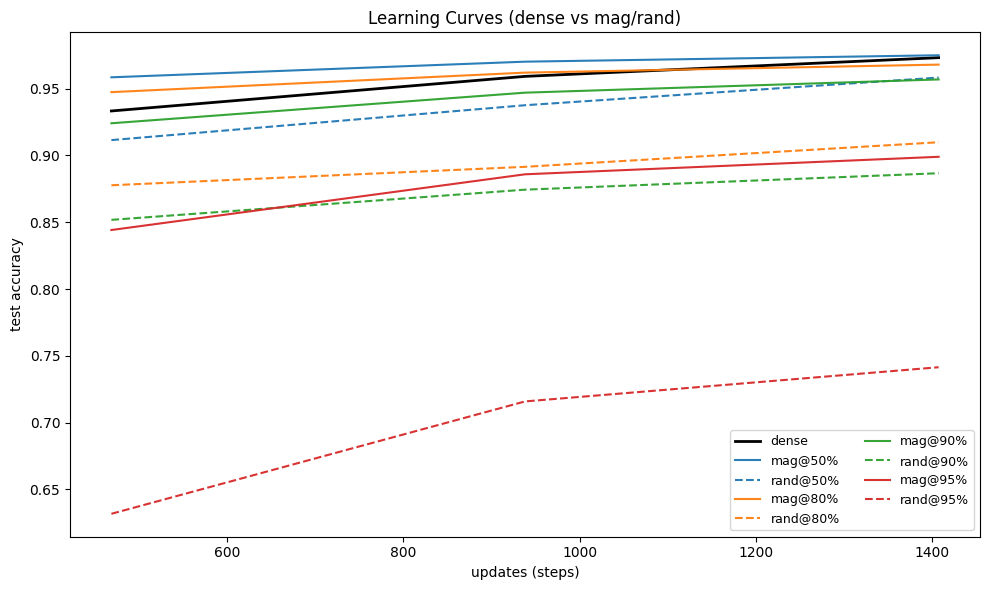

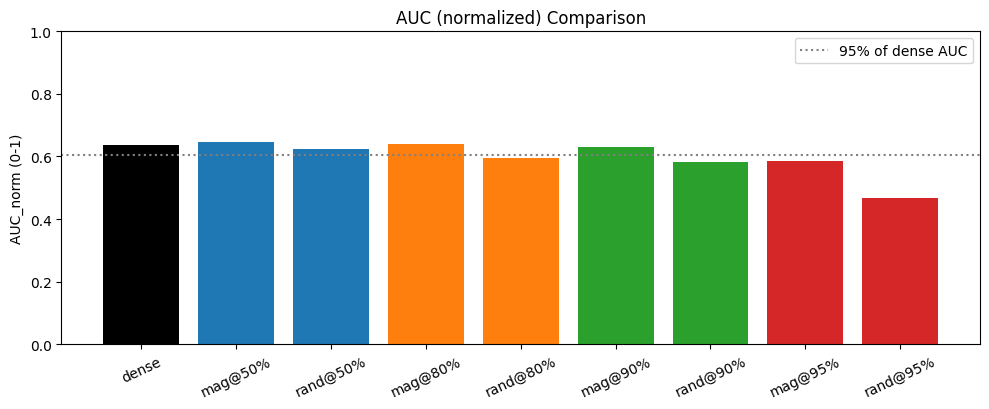

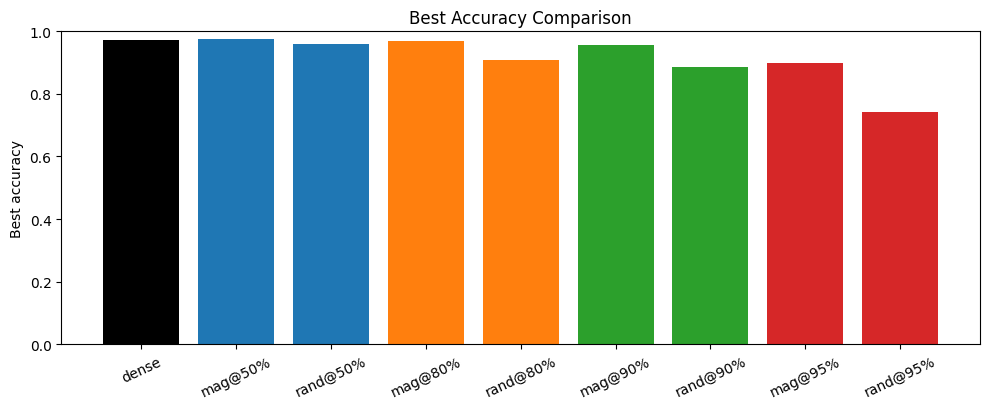


=== LTH (AUC_norm ≥ 95% of dense) 判定 ===
 @ 50%  |  mag: True (AUC=0.646)   /   rand: True (AUC=0.624)  |  dense=0.637
 @ 80%  |  mag: True (AUC=0.640)   /   rand: False (AUC=0.595)  |  dense=0.637
 @ 90%  |  mag: True (AUC=0.629)   /   rand: False (AUC=0.581)  |  dense=0.637
 @ 95%  |  mag: False (AUC=0.586)   /   rand: False (AUC=0.468)  |  dense=0.637


In [1]:
# @markdown 1) LTH判定は **dense の AUC_norm を基準**（候補が ≥95% で True）。
# @markdown 2) 可視化は **学習曲線／AUC比較／accuracy（Best）比較** の3種

# ========= 実験パラメータ =========
TARGET_SPARSITIES = [0.0, 0.5, 0.8, 0.9, 0.95]  # @param  # 目標疎度（0は密のベース）
PRUNE_STEP_FRACTION = 0.2     # @param {type:"number"}   # IMPの1回あたり削減率（20%）
USE_TQDM = True               # @param {type:"boolean"}  # 進捗バー表示
AUC_RATIO_REQ = 0.95          # @param {type:"number"}

# MNIST 側
MNIST_EPOCHS = 3              # @param {type:"integer"}  # 軽量デモ（提出時は 5〜10 など）
MNIST_BATCH = 128             # @param {type:"integer"}
MNIST_LR = 1e-3               # @param {type:"number"}
MNIST_T0_FRAC = 0.1           # @param {type:"number"}  # t0 を総更新の 10% に設定（早期リワインド）

# ========= SETUP =========
!pip -q install numpy matplotlib pandas torchvision tqdm

import time, random, copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from IPython.display import display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_global_seed(seed: int):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

# ========= ユーティリティ =========
def get_attr_by_name(obj, name: str):
    ref = obj
    for p in name.split('.'):
        ref = getattr(ref, p)
    return ref

def collect_weight_tensors_by_names(model: nn.Module, names: list):
    return [get_attr_by_name(model, n).detach().cpu() for n in names]

def iterative_magnitude_prune_masks(weights_by_layer, target_sparsity=0.9, step_fraction=0.2):
    """再学習を挟まない簡易IMP：小さい|w|から段階的に0へ。"""
    masks = [torch.ones_like(W) for W in weights_by_layer]
    total_elems = sum(W.numel() for W in weights_by_layer)
    target_zeros = int(total_elems * target_sparsity)
    def current_zeros(): return sum(int((m == 0).sum().item()) for m in masks)

    while current_zeros() < target_zeros:
        mags = torch.cat([torch.abs(W[m.bool()]).flatten() for W, m in zip(weights_by_layer, masks)])
        if mags.numel() == 0: break
        k = max(1, int(mags.numel() * step_fraction))
        thresh = torch.topk(mags, k, largest=False).values.max()
        for li, (W, m) in enumerate(zip(weights_by_layer, masks)):
            sel = (m == 1) & (torch.abs(W) <= thresh)
            masks[li][sel] = 0
    return masks

def random_masks_like(mag_masks, rng: np.random.Generator):
    """各層のゼロ数だけ同じランダムマスク"""
    rand_masks = []
    for M in mag_masks:
        M = M.clone()
        zeros = (M == 0).sum().item()
        flat = torch.ones_like(M).flatten()
        idx = rng.permutation(flat.numel())[:zeros]
        flat[idx] = 0
        rand_masks.append(flat.view_as(M))
    return rand_masks

def bind_masks_to_named_params(model: nn.Module, param_names: list, masks):
    """(Parameter, mask) のリストを返す"""
    bindings = []
    for name, mask in zip(param_names, masks):
        p: torch.nn.Parameter = get_attr_by_name(model, name)
        bindings.append((p, mask.to(device)))
    return bindings

def project_to_masks(bindings):
    for p, m in bindings: p.data.mul_(m)

def zero_pruned_grads(bindings):
    for p, m in bindings:
        if p.grad is not None: p.grad.data.mul_(m)

def compute_metrics_auc_and_best(curve_steps, curve_vals, total_steps, y_max):
    """
    返すもの：
      - AUC_norm: 台形近似 / (total_steps * y_max) で 0〜1 に正規化
      - BestAcc : 曲線上の最大値（MNISTは精度）
      - FinalAcc: 最終点の値（比較用）
    """
    steps = np.clip(np.asarray(curve_steps), 0, total_steps)
    vals  = np.asarray(curve_vals, dtype=np.float32)
    if len(steps) == 0:
        return dict(AUC_norm=0.0, BestAcc=0.0, FinalAcc=0.0)
    uniq_steps, uniq_indices = np.unique(steps, return_index=True)
    vals = vals[uniq_indices]
    auc = np.trapezoid(vals, uniq_steps) if len(vals) > 1 else 0.0
    auc_norm = float(auc / (total_steps * y_max)) if total_steps > 0 else 0.0
    best_acc = float(np.max(vals))
    final_acc = float(vals[-1])
    return dict(AUC_norm=auc_norm, BestAcc=best_acc, FinalAcc=final_acc)

def lth_by_auc_only(dense_auc_norm, cand_auc_norm, ratio_req=AUC_RATIO_REQ):
    """AUC_norm のみで判定：cand ≥ ratio_req * dense を LTH=True とする"""
    return cand_auc_norm >= ratio_req * max(1e-12, dense_auc_norm)

# ========= MNIST モデル（合計 17,410 パラメータ） =========
class MNISTNet(nn.Module):
    # conv1=70, conv2=128, fc1=14382, fc2=2830 → 合計 17410
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 7, kernel_size=3)    # 28->26
        self.pool1 = nn.MaxPool2d(2)                   # 26->13
        self.conv2 = nn.Conv2d(7, 2, kernel_size=3)    # 13->11
        self.pool2 = nn.MaxPool2d(2)                   # 11->5
        self.fc1   = nn.Linear(2*5*5, 282)             # 50->282
        self.fc2   = nn.Linear(282, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x)); x = self.pool1(x)
        x = F.relu(self.conv2(x)); x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x)); x = self.fc2(x)
        return x

def count_params(m): return sum(p.numel() for p in m.parameters())
assert count_params(MNISTNet()) == 17410, "Param mismatch (should be 17410)."

# ========= データローダ（Colab安定化：num_workers=0） =========
_transform = transforms.Compose([transforms.ToTensor()])
_train_ds = datasets.MNIST(root="./data", train=True,  download=True, transform=_transform)
_test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=_transform)

def make_loaders(seed):
    g = torch.Generator(); g.manual_seed(seed)
    pin = torch.cuda.is_available()
    train_loader = DataLoader(_train_ds, batch_size=MNIST_BATCH, shuffle=True,  num_workers=0, pin_memory=pin, generator=g)
    test_loader  = DataLoader(_test_ds,  batch_size=512,         shuffle=False, num_workers=0, pin_memory=pin)
    return train_loader, test_loader

@torch.no_grad()
def eval_mnist(model, test_loader):
    model.eval(); correct=0; total=0
    for xb,yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb); pred = logits.argmax(dim=1)
        correct += (pred==yb).sum().item(); total += yb.size(0)
    return correct/total

# ========= 密→IMPマスク作成 =========
def run_mnist_dense_and_masks(seed):
    set_global_seed(seed)
    train_loader, test_loader = make_loaders(seed)
    model = MNISTNet().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=MNIST_LR)
    crit = nn.CrossEntropyLoss()

    total_steps = MNIST_EPOCHS * len(train_loader)
    t0_steps = max(1, int(total_steps * MNIST_T0_FRAC))
    step=0; steps_curve=[]; acc_curve=[]; t0_state=None

    p_outer = tqdm(range(1, MNIST_EPOCHS+1), desc=f"Dense(seed={seed})", leave=False) if USE_TQDM else range(1, MNIST_EPOCHS+1)
    for epoch in p_outer:
        model.train()
        p = tqdm(train_loader, desc=f"train e{epoch}", leave=False) if USE_TQDM else train_loader
        for xb,yb in p:
            xb,yb = xb.to(device), yb.to(device)
            logits = model(xb); loss = crit(logits,yb)
            opt.zero_grad(); loss.backward(); opt.step()
            step += 1
            if step == t0_steps:
                t0_state = copy.deepcopy(model.state_dict())
        acc = eval_mnist(model, test_loader)
        steps_curve.append(step); acc_curve.append(acc)

    if t0_state is None: t0_state = copy.deepcopy(model.state_dict())

    # マスク作成（最終重みのマグニチュードで）
    layer_names = ["conv1.weight","conv2.weight","fc1.weight","fc2.weight"]
    weights_final = collect_weight_tensors_by_names(model, layer_names)
    mag_masks = {}
    rand_masks = {}
    for sp in TARGET_SPARSITIES:
        if sp == 0.0: continue
        mag = iterative_magnitude_prune_masks(weights_final, target_sparsity=sp, step_fraction=PRUNE_STEP_FRACTION)
        mag_masks[sp] = mag
        rng = np.random.default_rng(seed + int(sp*1000) + 2024)
        rand_masks[sp] = random_masks_like(mag, rng)

    # 指標（AUC_norm / BestAcc / FinalAcc）
    dense_metrics = compute_metrics_auc_and_best(steps_curve, acc_curve, total_steps=total_steps, y_max=1.0)
    return (dense_metrics, (np.array(steps_curve), np.array(acc_curve))), t0_state, layer_names, mag_masks, rand_masks, total_steps

# ========= t0へリワインド＋マスク適用で再学習 =========
def run_mnist_ticket(seed, t0_state, layer_names, masks, kind_desc, total_steps):
    train_loader, test_loader = make_loaders(seed + (123 if kind_desc.startswith("mag") else 456))
    model = MNISTNet().to(device)
    model.load_state_dict(copy.deepcopy(t0_state))
    bindings = bind_masks_to_named_params(model, layer_names, masks)
    project_to_masks(bindings)
    opt = torch.optim.Adam(model.parameters(), lr=MNIST_LR)
    crit = nn.CrossEntropyLoss()

    step=0; steps_curve=[]; acc_curve=[]
    p_outer = tqdm(range(1, MNIST_EPOCHS+1), desc=kind_desc, leave=False) if USE_TQDM else range(1, MNIST_EPOCHS+1)
    for epoch in p_outer:
        model.train()
        p = tqdm(train_loader, desc=f"train e{epoch}", leave=False) if USE_TQDM else train_loader
        for xb,yb in p:
            xb,yb = xb.to(device), yb.to(device)
            logits = model(xb); loss = crit(logits,yb)
            opt.zero_grad(); loss.backward()
            zero_pruned_grads(bindings)
            opt.step()
            project_to_masks(bindings)
            step += 1
        acc = eval_mnist(model, test_loader)
        steps_curve.append(step); acc_curve.append(acc)

    metrics = compute_metrics_auc_and_best(steps_curve, acc_curve, total_steps=total_steps, y_max=1.0)
    return metrics, (np.array(steps_curve), np.array(acc_curve))

# ========= 実行（seed固定=0の1回のみ） =========
SEED = 0
print(f"Device: {device}  |  SEED: {SEED}")
start = time.time()

(dense_metrics, (steps_dense, acc_dense)), t0_state, layer_names, mag_masks, rand_masks, total_steps = run_mnist_dense_and_masks(SEED)

rows = []
curves = {"dense": (steps_dense, acc_dense)}
rows.append(dict(kind="dense", sparsity=0.0, **dense_metrics))

for sp in TARGET_SPARSITIES:
    if sp == 0.0: continue
    m_met, (s_m, a_m) = run_mnist_ticket(SEED, t0_state, layer_names, mag_masks[sp], f"mag@{int(sp*100)}%", total_steps)
    r_met, (s_r, a_r) = run_mnist_ticket(SEED, t0_state, layer_names, rand_masks[sp], f"rand@{int(sp*100)}%", total_steps)
    curves[f"mag@{int(sp*100)}%"]  = (s_m, a_m)
    curves[f"rand@{int(sp*100)}%"] = (s_r, a_r)
    # === LTH 判定（AUC_norm のみ） ===
    flag_m = lth_by_auc_only(dense_metrics["AUC_norm"], m_met["AUC_norm"])
    flag_r = lth_by_auc_only(dense_metrics["AUC_norm"], r_met["AUC_norm"])
    rows.append(dict(kind="mag",  sparsity=sp, LTH=flag_m, **m_met))
    rows.append(dict(kind="rand", sparsity=sp, LTH=flag_r, **r_met))

elapsed = time.time() - start

# ========= 表示（AUC基準の集計） =========
df = pd.DataFrame(rows)
# 列の並びを整える
base_cols = ["kind","sparsity","LTH","AUC_norm","BestAcc","FinalAcc"]
df = df[base_cols]
print("集計（seed=0, 1回のみ / LTH= AUC_norm ≥ %.0f%% * dense ）：" % (AUC_RATIO_REQ*100))
display(df.sort_values(["kind","sparsity"]).reset_index(drop=True))

# ========= 可視化（3プロット）：学習曲線／AUC比較／accuracy（Best）比較 =========
import matplotlib as mpl
cmap = mpl.cm.get_cmap("tab10")
sp_list = [sp for sp in TARGET_SPARSITIES if sp != 0.0]
color_map = {sp: cmap(i % 10) for i, sp in enumerate(sp_list)}

# (1) 学習曲線（dense + 各疎度の mag/rand を重ねて表示）
plt.figure(figsize=(10, 6))
s, a = curves["dense"]
plt.plot(s, a, label="dense", color="black", linewidth=2)
for sp in sp_list:
    sm, am = curves[f"mag@{int(sp*100)}%"]
    sr, ar = curves[f"rand@{int(sp*100)}%"]
    plt.plot(sm, am, label=f"mag@{int(sp*100)}%", color=color_map[sp], alpha=0.95)
    plt.plot(sr, ar, label=f"rand@{int(sp*100)}%", color=color_map[sp], linestyle="--", alpha=0.95)
plt.xlabel("updates (steps)")
plt.ylabel("test accuracy")
plt.title("Learning Curves (dense vs mag/rand)")
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

# (2) AUC比較（正規化AUCの棒グラフ）
order = [("dense",0.0)] + [(k,sp) for sp in sp_list for k in ("mag","rand")]
labels_auc, vals_auc, cols_auc = [], [], []
dense_auc = df[(df["kind"]=="dense") & (df["sparsity"]==0.0)]["AUC_norm"].values[0]
for kind, sp in order:
    row = df[(df["kind"]==kind) & (df["sparsity"]==sp)]
    if len(row)==0: continue
    labels_auc.append(f"{kind}@{int(sp*100)}%" if sp>0 else "dense")
    vals_auc.append(float(row["AUC_norm"].values[0]))
    cols_auc.append("black" if sp==0 else color_map[sp])

plt.figure(figsize=(10, 4.2))
bars = plt.bar(labels_auc, vals_auc, color=cols_auc)
plt.axhline(dense_auc*AUC_RATIO_REQ, color="gray", linestyle=":", linewidth=1.5,
            label=f"{int(AUC_RATIO_REQ*100)}% of dense AUC")
plt.ylim(0, 1.0); plt.ylabel("AUC_norm (0-1)")
plt.title("AUC (normalized) Comparison")
plt.xticks(rotation=25)
plt.legend()
plt.tight_layout()
plt.show()

# (3) accuracy比較（Best accuracy＝曲線の最大精度）
labels_acc, vals_acc, cols_acc = [], [], []
for kind, sp in order:
    row = df[(df["kind"]==kind) & (df["sparsity"]==sp)]
    if len(row)==0: continue
    labels_acc.append(f"{kind}@{int(sp*100)}%" if sp>0 else "dense")
    vals_acc.append(float(row["BestAcc"].values[0]))
    cols_acc.append("black" if sp==0 else color_map[sp])

plt.figure(figsize=(10, 4.2))
plt.bar(labels_acc, vals_acc, color=cols_acc)
plt.ylim(0, 1.0); plt.ylabel("Best accuracy")
plt.title("Best Accuracy Comparison")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

# ========= LTH（AUC基準）判定をわかりやすく表示 =========
print("\n=== LTH (AUC_norm ≥ %.0f%% of dense) 判定 ===" % (AUC_RATIO_REQ*100))
for sp in sp_list:
    m_row = df[(df["kind"]=="mag")  & (df["sparsity"]==sp)].iloc[0]
    r_row = df[(df["kind"]=="rand") & (df["sparsity"]==sp)].iloc[0]
    print(f" @ {int(sp*100)}%  |  mag: {m_row['LTH']} (AUC={m_row['AUC_norm']:.3f})"
          f"   /   rand: {r_row['LTH']} (AUC={r_row['AUC_norm']:.3f})  |  dense={dense_auc:.3f}")

### 【作成者】

川島能就

### 【参考】
- ChatGPT（コーディング）
- 「宝くじ仮説」論文（[The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks](https://arxiv.org/abs/1803.03635))

- 「強い宝くじ仮説」論文 ([What's Hidden in a Randomly Weighted Neural Network?](https://arxiv.org/abs/1911.13299))
